# **Task 2** 개요

안녕하세요? 저희는 이번 제 3회 데이터 사이언스 공모전에 참가한 팀 '아벱퍼' 입니다. (이재헌, 송요셉, 조성혜, 최찬영)

저희가 Task 2를 어떻게 수행했는지 설명드리겠습니다.

### 접근 방식 요약

먼저, 저희는 Task 1에서 예측했던 값을 기반으로 Task 2를 수행하였습니다. Task 2에서는 Weekly Data만 사용해서 예측하였습니다.

Task 2에서는 비행기로 주문하는 비용이 크기 때문에 이를 예방하고자 미리 여유분의 재고를 구비해놓아야 된다고 생각했습니다. 하지만 너무 많이 주문해서 재고가 많이 남으면 안 되기 때문에 적정량을 주문해야 합니다.

접근 방식: 제품별로 Task1의 결과의 첫 주차에 k개만큼 더해주고, 마지막 두 주차에 m개만큼 빼기. **Optimal k and m 을 구하기**. <br>
ex) task 1의 결과가 [10,...,10,10] 이었고 k=5, m=1이면 [10+5, ..., 10-1, 10-1] = [15, ... , 9, 9] 이렇게 주문하도록 설계하였습니다.

### **방법 A : Empirical Distribution**

Optimal k and m 을 구하는 과정은 아래와 같습니다.

0. (가정) 예측할 13주의 주문량은 최근 주문량의 통계를 따를 것이다.

1. 2023년 데이터(최근 30주 데이터)의 주문량의 분포를 기반으로 확률 분포를 만듭니다. 예를 들어, 30주 동안 주문량이 3인 적이 두 번 있다면 주문량이 3일 확률은 2/30 = 1/15가 되는 것입니다. 이런 식으로 각 제품마다 2023년도의 주문량의 확률 분포를 구합니다. (Empirical Distribution)

2. 1에서 구한 확률 분포로 각 제품별로 예측해야할 12주(13주이지만 첫 주의 데이터는 주어졌습니다.)의 랜덤 샘플을 제품별로 만 개를 만듭니다. 랜덤 샘플의 형식은 다음과 같습니다. <br>
rnd_sample = [TEST_0(list), TEST_1, ..., TEST_9] <br>
TEST_i = [sample0(list), sample1, ..., sample9999] <br>
sample0 = [week1 주문량(int), ..., week12 주문량] <br>

3. k와 m 값을 설정한 후, Task1의 첫 주에 k만큼 더하고, 마지막 두 주에 m만큼 빼줍니다. 이를 Task1(k,m)이라고 하겠습니다.

4. 각 제품별로 만 개의 sample이 있습니다. Task1(k,m) (예측값) 과 sample_i(참값이라고 가정)의 relative total cost를 구합니다. 만 개의 sample에 대해 relative_total_cost(rtc)를 구한 다음 평균을 냅니다. 이를 rtc(k,m)이라고 하겠습니다.

5. k와 m값을 바꿔가면서 rtc(k,m)을 구한 후, rtc(k,m)이 가장 작았던 k,m 을 구해서 이를 Task1 값에 적용하여 Task2 를 구하였습니다. (4를 반복)



### **방법 B : Poisson Distribution**

방법 A의 1번 과정의 확률 분포를 2023년도의 주문량 평균을 가지는 푸아송 분포로 대체한 후, 방법 A와 동일한 과정 진행

저희는 아래 그림처럼 주문량이 많지 않은 6가지 제품들의 5년간의 주문량 분포가 푸아송 분포를 따른다는 것을 발견했습니다. 하지만 이 분포는 최근의 경향을 반영하지 못합니다. 예를 들면 5년간 주문량 평균이 2개여도 최근에는 3,4개와 같은 주문량을 보입니다. 하지만 최근 주문량 역시 푸아송 분포를 따를 것이라고 가정했습니다.

따라서, 이 6개의 제품에 대해서는 2023년도의 주문량 평균값을 바탕으로 **푸아송 분포를 통해서 랜덤 샘플을 구했습니다.**

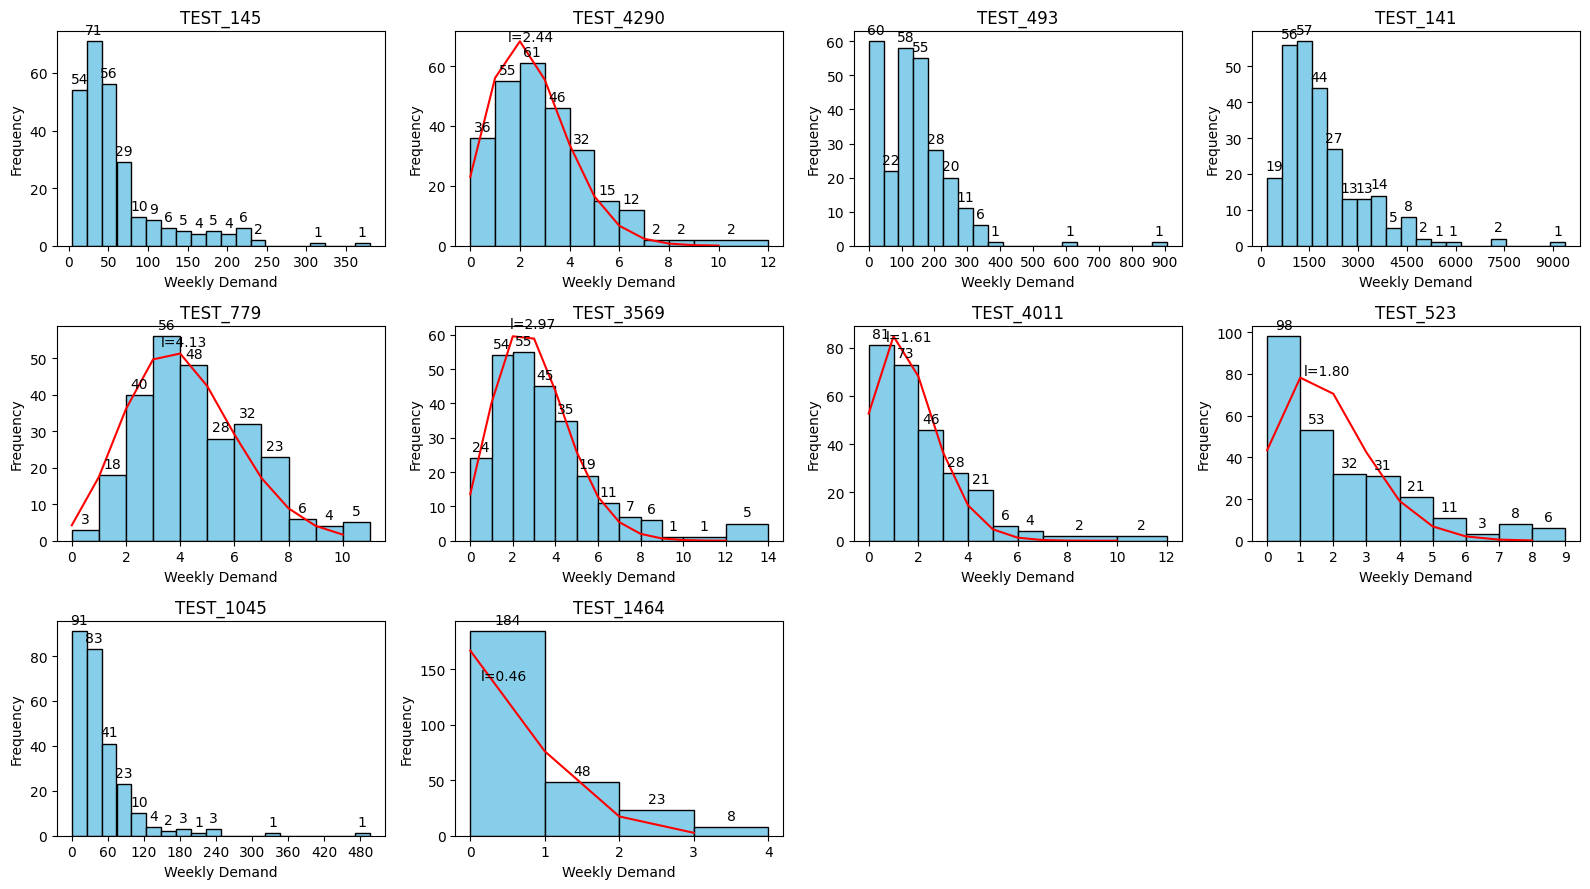

### **접근 방식 결론**

주문량이 많았던 4개의 제품(TEST_145, TEST_493, TEST_141, TEST_1045)에 대해서는 방법 A로, 주문량이 적었던 나머지 6개의 제품에 대해서는 방법 B로 Task2를 수행하였습니다.

이렇게 구한 결과에서 데이터의 경향성을 따라서 조금씩 늘리고 줄여주긴 했습니다만, 그 폭은 미미합니다.

# 코드 시작

## **Data Import**

In [ ]:
# Data import

# 보안상의 이유로 생략

In [ ]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import scipy
import math

## **Function Definitions**

In [ ]:
def data_sort(cd_int): # input: 'TEST_141'과 같은 cd_int(code_interested),  output: 주별 주문량이 시간순으로 정렬된 data frame
    years = list(set(data_weekly['year']))
    data_weekly_new = data_weekly.copy()
    data_weekly_new.loc[:, 'week_year'] = data_weekly['week'] + data_weekly['year'] * 100
    wys = list(set(data_weekly_new['week_year']))
    wys.sort()
    data_interest = data_weekly_new[data_weekly['part_no'] == cd_int]

    # preprocessing
    data_interest = data_interest[['week_year','actual','year','week']]
    wys_data = list(set(data_interest['week_year']))
    wy_start = min(wys_data)
    data_interest
    for wy in wys:
        if (wy not in wys_data) & (wy > wy_start):
            data_interest = pd.concat([data_interest,pd.DataFrame({'week_year':[wy],'actual':[0],'year':[wy//100],'week':[wy%100]}) ])

    data_interest_new = data_interest.copy()
    data_interest_new['index'] = data_interest['week_year'].apply(lambda x: wys.index(x))

    # Sort the DataFrame by 'week_year'
    sorted_data = data_interest_new.sort_values(by='week_year')
    sorted_data = sorted_data.set_index("index")
    return sorted_data


In [ ]:
def relativeMSE(y_test,y_predict):  # Relativ MSE 함수: input: y_test, y_predict list or array, output: relative MSE
    zero_MSE = np.square(np.array(y_test)).mean()
    a = (np.array(list(y_test)) - np.array(list(y_predict)))
    MSE = np.square(a).mean()
    return MSE/zero_MSE

In [ ]:
# Relative MSE 함수 잘 짰는지 검증
relativeMSE([2,2,2],[2,2,2])

0.0

### Relative Total Cost 함수 구현

In [ ]:
import numpy as np
# y_pred: N x W / y_true: N x D x W / output: N x D
def relative_total_cost(y_pred,y_true): # input: y_pred & y_true, output: Relative Total Cost
  costs = [1, 14.576521741, 65.63826087] # [carrying, ship, air]
  y_true = np.array(y_true)
  (N, D, W) = y_true.shape
  y_pred = np.tile(np.array(y_pred).reshape(N, 1, W), (1, D, 1))
  inventory = np.zeros((N, D, W))

  for i in range(1, W):
    inventory[:, :, i] = np.maximum(inventory[:, :, i-1] + y_pred[:, :, i-1]-y_true[:, :, i-1], 0)
  # print(np.tile(y_pred.reshape(N, 1, W), (1, D, 1)).shape)

  our_cost = costs[0] * inventory # 재고 유지비
  our_cost += costs[1] * y_pred # 예측한 만큼은 여유롭게 배로 운송
  our_cost += costs[2] * np.maximum(y_true-y_pred-inventory, 0) # 예측 실패한 만큼은 급하게 비행기로 운송
  # print(our_cost.shape)
  our_cost = our_cost.sum(axis=2)
  zero_cost = np.sum(costs[2] * y_true, axis=2)

  return our_cost/zero_cost

# Relative Total Cost 함수 잘 짰는지 검증
arr = np.array([[2,3,2], [3,4,2]])
arr2 = np.array([[[3,4,2]], [[2,2,2]]])
print(arr2.shape)
relative_total_cost(arr, arr2) #np.zeros(arr.shape)

(2, 1, 3)


array([[0.3949461 ],
       [0.34326701]])

Random Seed 고정

In [ ]:
np.random.seed(17)

In [ ]:
cd_interests = ['TEST_145',
                'TEST_4290',
                'TEST_493',
                'TEST_141',
                'TEST_779',
                'TEST_3569',
                'TEST_4011',
                'TEST_523',
                'TEST_1045',
                'TEST_1464'
                ]

## **Random Data Generation with the Empirical Distribution**

### **Empirical Distribution Visualization: 2023년도 주문량 분포 확인**

Number of weeks in 2023:  31


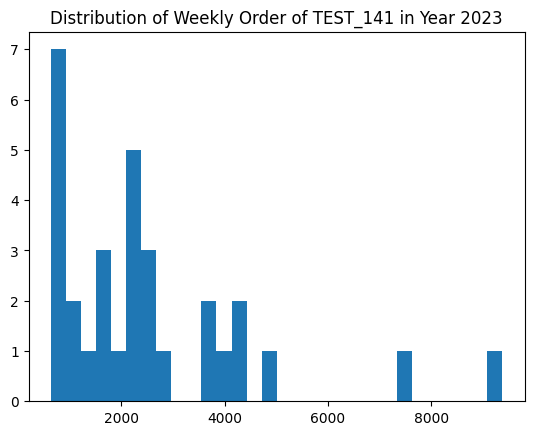

In [ ]:
part = 'TEST_141'

df = data_sort(part)
df = df[df['year']>=2023]['actual']
mean = np.mean(df)
plt.hist(df.values,bins=30)
plt.title(f"Distribution of Weekly Order of {part} in Year 2023")

print("Number of weeks in 2023: ",len(df))

### **Generating Random Samples with Empirical Distributions**

In [ ]:
emp_prob = [] # 제품별 2023년도 주문량 Empirical probability distribution 으로 만든 랜덤 데이터
stat_emp = [] # 제품별 2023년도 주문량 (평균, 분산)
for i in range(10):
  temp = []
  df = data_sort(cd_interests[i])
  df = df[df['year']>=2023]['actual']
  m = max(df)+1
  dist = np.zeros(m) # 주문량의 최댓값 길이만큼 0 array 생성
  for j in range(len(df)):
    dist[df.iloc[j]] += 1 # 주문량 index에 1 더해주기
  dist = dist/len(df) # 2023년도 데이터 개수로 나누어 확률분포가 되게 해주기
  for k in range(10000):
    arr = np.random.choice(m,12,p=dist) # Random sample 생성
    temp.append(arr)
  emp_prob.append(temp)
  stat_emp.append((np.mean(df),np.std(df)))

emp_prob = np.array(emp_prob)
stat_emp = np.array(stat_emp)

In [ ]:
print('shape of "emp_prob":', emp_prob.shape)
print('\nfor example... 7th sample list: ')
pd.DataFrame(emp_prob[:,7,:].T, columns=cd_interests, index=['Week'+str(k) for k in range(2,14)])

shape of "emp_prob": (10, 10000, 12)

for example... 7th sample list: 


,TEST_145,TEST_4290,TEST_493,TEST_141,TEST_779,TEST_3569,TEST_4011,TEST_523,TEST_1045,TEST_1464
Week2,59,5,147,1441,4,2,4,3,44,0
Week3,64,1,100,1536,4,2,3,7,44,1
Week4,70,2,89,753,3,0,4,0,27,0
Week5,21,2,98,4063,2,2,3,3,39,0
Week6,69,6,94,1724,3,0,2,2,55,3
Week7,159,4,103,2637,2,2,0,2,46,1
Week8,64,4,145,4394,4,6,4,0,34,3
Week9,69,5,140,2637,4,6,0,1,44,0
Week10,174,3,94,4857,7,6,4,1,27,0
Week11,98,5,92,2220,3,2,2,2,34,0


In [ ]:
#2023년도 말고 2019년부터의 데이터로도 empirical distribution을 구했었지만 결과가 안 좋아서 버렸습니다.

# emp_prob_entire = []
# stat_emp_entire = []
# for i in range(10):
#   temp = []
#   df = data_sort(cd_interests[i])
#   df = df[df['year']>=2019]['actual']
#   m = max(df)+1
#   dist = np.zeros(m)
#   for j in range(len(df)):
#     dist[df.iloc[j]] += 1
#   dist = dist/len(df)
#   for k in range(10000):
#     arr = np.random.choice(m,12,p=dist)
#     temp.append(arr)
#   emp_prob_entire.append(temp)
#   stat_emp_entire.append((np.mean(df),np.std(df)))

## Set up

### Task 1 Predicted Results
Task 1 결과를 튜플에 담았습니다.

In [ ]:
task1 = ((68,58,50,59,73,67,52,52,67,71,59,51), (4,4,4,4,4,4,4,4,4,4,4,4), (172,171,171,170,170,169,169,169,168,168,168,167),
         (2514,2513,2513,2513,2512,2512,2511,2511,2510,2509,2509,2508), (3,3,3,3,3,3,3,3,3,3,3,3), (2,2,2,2,2,2,2,2,2,2,2,2),
         (3,3,3,3,3,3,3,3,3,3,3,3), (4,3,3,3,3,3,3,3,3,3,3,3), (34,34,34,33,33,33,32,32,32,31,31,31), (1,1,1,1,1,1,1,1,1,1,1,0))
pd.DataFrame(np.array(task1).T, columns=cd_interests, index=['week'+str(k) for k in range(2, 14)])

,TEST_145,TEST_4290,TEST_493,TEST_141,TEST_779,TEST_3569,TEST_4011,TEST_523,TEST_1045,TEST_1464
week2,68,4,172,2514,3,2,3,4,34,1
week3,58,4,171,2513,3,2,3,3,34,1
week4,50,4,171,2513,3,2,3,3,34,1
week5,59,4,170,2513,3,2,3,3,33,1
week6,73,4,170,2512,3,2,3,3,33,1
week7,67,4,169,2512,3,2,3,3,33,1
week8,52,4,169,2511,3,2,3,3,32,1
week9,52,4,169,2511,3,2,3,3,32,1
week10,67,4,168,2510,3,2,3,3,32,1
week11,71,4,168,2509,3,2,3,3,31,1


### Statistics (Mean, Std)

2023년도 주문량의 평균과 표준편차, 마지막 13주차 주문량의 평균과 표준편차, 두 통계량의 평균을 구했습니다.

In [ ]:
data_2023 = [] # 2023년도 주문 개수
stat_2023 = [] # 2023년도 주문 개수의 평균, 표준편차
data_last_13 = [] # 마지막 13주 주문 개수
stat_last_13 = [] # 마지막 13주 주문 개수의 평균, 표준편차
for i in range(10):
  df = data_sort(cd_interests[i])
  df = df[df['year']>=2023]['actual']
  data_2023.append(list(df))
  stat_2023.append([np.mean(df), np.std(df)])
  data_last_13.append(data_2023[i][-13:])
  stat_last_13.append([np.mean(data_last_13[i]),np.std(data_last_13[i])])

In [ ]:
stat_avg = [] # stat_2023과 stat_last_13의 평균
for i in range(10):
  stat_avg.append([(stat_2023[i][0] + stat_last_13[i][0])/2,(stat_2023[i][1] + stat_last_13[i][1])/2])

std_avg = []
for i in range(10):
  std_avg.append(stat_avg[i][1])

print("stat_2023과 stat_last_13의 평균:\n")
pd.DataFrame(stat_avg, columns=['mean', 'std'], index=cd_interests)

stat_2023과 stat_last_13의 평균:



,mean,std
TEST_145,55.483871,33.315145
TEST_4290,4.277916,2.450633
TEST_493,153.522333,46.002319
TEST_141,2635.255583,2243.925967
TEST_779,3.163772,1.371795
TEST_3569,1.538462,1.358762
TEST_4011,2.980149,1.617809
TEST_523,3.481390,2.893563
TEST_1045,41.750620,15.099433
TEST_1464,0.450372,0.599554


## **Main Function**

- ``how_much_add_and_minus`` : Random sample과의 Relative Total Cost를 계산해 최적의 k,m을 구하는 함수
  - input ``rnd_samples``: randomly sampled data. (N x D x W)
  - input ``task1``: task 1 predicted values. (N x W)
  - input ``stat``: statistics (mean, std) of each part. (N x 2)


> - N: number of parts in interest. N = 10
> - D: length of sampled data. D = 10000
> - W: number of weeks to predict. W= 12


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

In [ ]:
from tqdm import tqdm
from copy import deepcopy
# "Random sample과의 Relative Total Cost를 계산해 최적의 k,m을 구하는 함수"

def how_much_add_and_minus(rnd_samples, task1, stat):
  rnd_samples = np.array(rnd_samples)
  pred = np.array(task1).astype('int')
  stat = np.array(stat)
  (N, D, W) = rnd_samples.shape

  # parameters
  k_step = 0.1 # k를 0.1*sigma 만큼씩 증가시키면서 계산
  m_step = 0.05 # m을 0.05*sigma 만큼씩 증가시키면서 계산
  k_cycle, m_cycle = 40, 20

  best_k, best_m = np.full(10, fill_value=-1.0), np.full(10, fill_value=-1.0)
  best_rtc = np.full(10, fill_value=np.inf)
  for i, k in enumerate(tqdm(np.arange(0, k_cycle*k_step, k_step))):
    # add k
    new_k = np.round(k * stat[:, 1])
    new_pred = deepcopy(pred)
    new_pred[:, 0] = new_pred[:, 0] + new_k

    # subtract m
    for j, m in enumerate(np.arange(0, m_cycle*m_step, m_step)):
      new_m = np.round(m * stat[:,1])
      new_pred[:, -1] = np.maximum(new_pred[:, -1] - new_m, 0)
      new_pred[:, -2] = np.maximum(new_pred[:, -2] - new_m, 0)

      rtc_by_k_and_m = np.mean(relative_total_cost(new_pred, rnd_samples), axis=1)
      idx = rtc_by_k_and_m < best_rtc
      if idx.sum() > 0:
        # print(k, m, idx, new_k[idx], new_m[idx])
        best_rtc[idx] = rtc_by_k_and_m[idx]
        best_k[idx] = k
        best_m[idx] = m

  how_much_sigma = np.concatenate((best_k.reshape(-1,1), best_m.reshape(-1,1), best_rtc.reshape(-1,1)), axis=1)
  return how_much_sigma
  # 각 제품별로 몇 sigma를 더해주고 뺄 건지 정합니다. 예를 들면 [2, 0.5]로 나왔다면, 첫 주에 2 sigma, 마지막 두 주에 0.5 sigma를 빼줍니다.


how_much_sigma_to_add_and_minus = how_much_add_and_minus(emp_prob, task1, stat_avg)

100%|██████████| 40/40 [01:00<00:00,  1.51s/it]


## **Results**

In [ ]:
pd.DataFrame(how_much_sigma_to_add_and_minus, index=cd_interests, columns=['add_ratio', 'subtract_ratio', 'best_rtc']).astype('float') # print the result for each cycle

,add_ratio,subtract_ratio,best_rtc
TEST_145,3.7,0.20,0.311929
TEST_4290,1.5,0.35,0.311432
TEST_493,0.7,0.55,0.276801
TEST_141,2.2,0.25,0.335326
TEST_779,2.6,0.40,0.287505
TEST_3569,2.6,0.40,0.346167
TEST_4011,1.6,0.35,0.301675
TEST_523,2.3,0.25,0.365444
TEST_1045,3.9,0.00,0.301201
TEST_1464,-1.0,-1.00,inf


In [ ]:
how_much_to_add_and_minus = []
std_avg = np.array(std_avg)

how_much_to_add_and_minus = (np.tile(std_avg.reshape(-1,1), (1, 2)) * how_much_sigma_to_add_and_minus[:, :2]).astype('int')
pd.DataFrame(how_much_to_add_and_minus, index=cd_interests, columns=['add', 'subtract'])

,add,subtract
TEST_145,123,6
TEST_4290,3,0
TEST_493,32,25
TEST_141,4936,560
TEST_779,3,0
TEST_3569,3,0
TEST_4011,2,0
TEST_523,6,0
TEST_1045,58,0
TEST_1464,0,0


위의 결과 해석 <br>
TEST_145의 sigma $≃ $ 33 <br>
k = 3.7, m = 0.2

$⇒ $ 첫주차: k * sigma = 3.7 * 33 = 123 개 더하기

$⇒ $ 마지막 두 주: m * sigma = 6 개 각각 빼기

## Poisson Fitting Visualization

**주문량이 적은 수의 제품들의 주문량 분포가 푸아송 분포를 따른다는 것을 보여주기 위한 부분입니다. 맨 아래의 그림만 보시면 됩니다.**

In [ ]:
def poisson_func(lmbd, t):
    x = np.power(lmbd, t) * np.exp(-lmbd)
    y = scipy.special.factorial(t)
    poisson = np.nan_to_num(x/y, nan=0, posinf=33333333)
    return poisson

In [ ]:
week_part = data_weekly.drop(columns=['com_cd', 'branch_cd'])

week_part['yearweek'] = week_part['year'].astype(str) + '-' +week_part['week'].astype(str).str.zfill(2)

# print('2020-53' in set(week_part['yearweek']))

week_part = week_part.groupby(['yearweek', 'part_no'])['actual'].sum().unstack()
week_part.fillna(0, inplace=True)
week_part = week_part.astype(int)
week_part.head()

part_no,TEST_0,TEST_1,TEST_10,TEST_100,TEST_1000,TEST_1001,TEST_1003,TEST_1005,TEST_1006,TEST_1007,...,TEST_981,TEST_982,TEST_983,TEST_984,TEST_986,TEST_99,TEST_991,TEST_993,TEST_995,TEST_999
yearweek,,,,,,,,,,,,,,,,,,,,,
2018-30,0,0,0,0,0,0,0,0,0,0,...,174,0,0,0,0,0,0,0,0,0
2018-31,0,0,0,0,0,0,0,0,0,0,...,461,41,0,0,0,0,0,1,0,0
2018-32,0,0,0,2,0,0,0,0,0,0,...,293,40,0,0,0,0,0,0,0,0
2018-33,0,0,0,1,0,0,0,0,0,0,...,351,26,0,0,0,0,0,0,0,0
2018-34,0,0,0,1,0,0,0,0,0,0,...,414,21,0,0,0,0,0,0,0,0


In [ ]:
important_part = ['TEST_145', 'TEST_4290', 'TEST_493', 'TEST_141', 'TEST_779', 'TEST_3569', 'TEST_4011', 'TEST_523', 'TEST_1045', 'TEST_1464']
imp_week_part = week_part[important_part]
imp_week_part.head()

part_no,TEST_145,TEST_4290,TEST_493,TEST_141,TEST_779,TEST_3569,TEST_4011,TEST_523,TEST_1045,TEST_1464
yearweek,,,,,,,,,,
2018-30,9,0,0,195,2,0,0,0,0,0
2018-31,9,0,0,1164,3,2,1,0,0,0
2018-32,23,2,0,1448,3,3,0,0,0,0
2018-33,10,2,0,745,4,6,0,0,0,0
2018-34,8,0,0,805,5,4,1,0,0,0


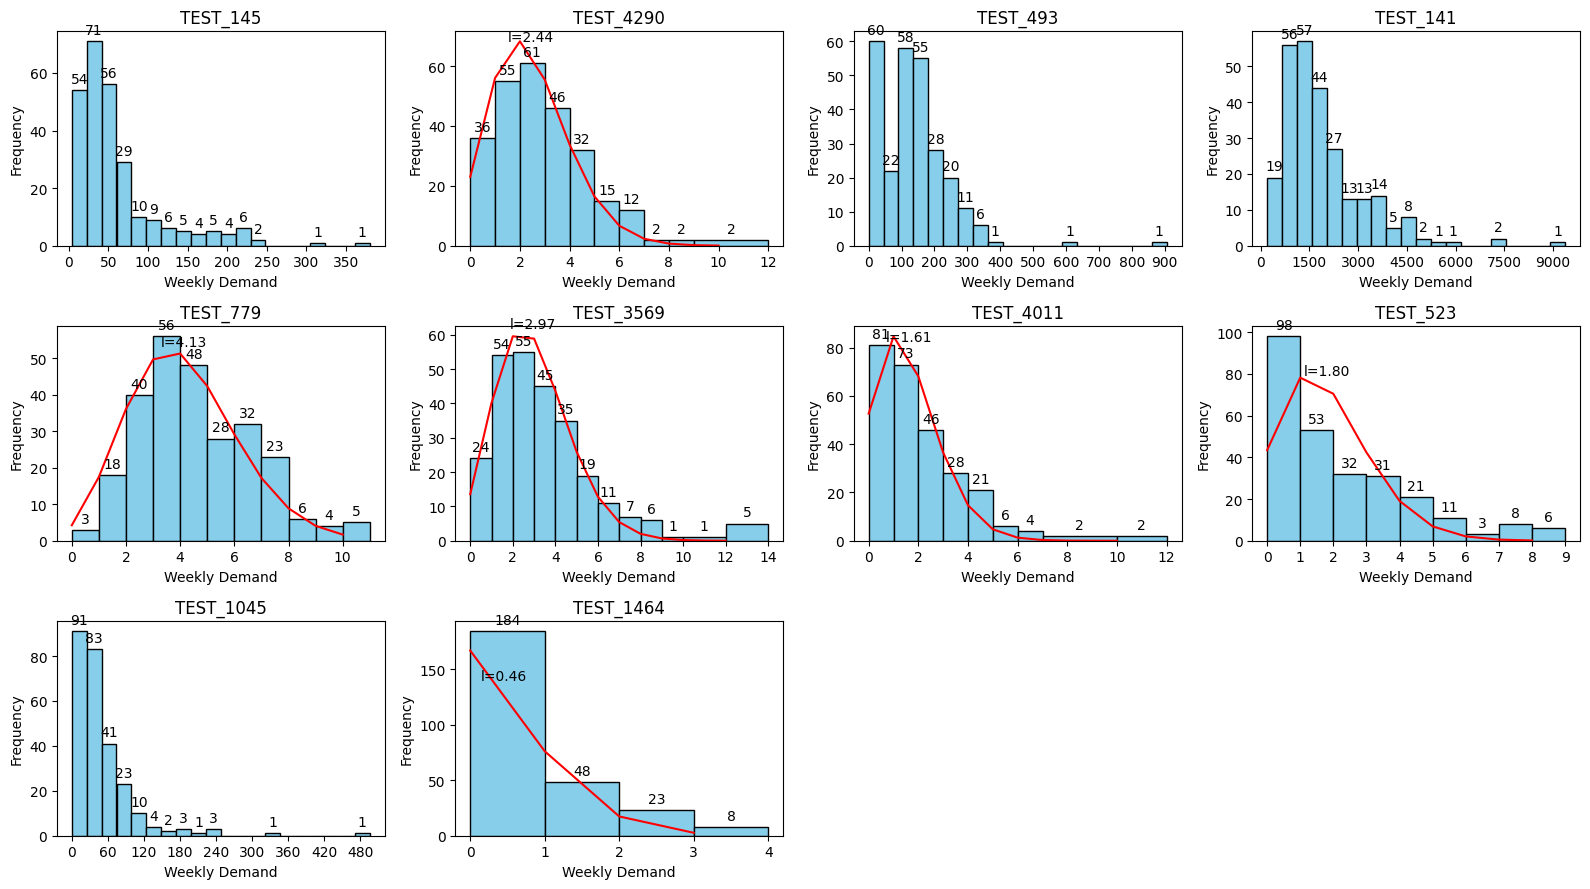

In [ ]:
data = imp_week_part

# Create subplots for each column
num_cols = int(np.ceil(len(data.columns) / 3))
num_rows = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 3*num_rows))
axes = axes.flatten()

# Plot histograms for each column
for i, col in enumerate(data.columns):
    bins = sorted(list(set(data[col])))
    if len(bins) > 20 :
      bins = 20
    axes[i].hist(data[col], bins = bins, color='skyblue', edgecolor='black')  # Adjust bins as needed
    axes[i].set_title(col)
    axes[i].set_xlabel('Weekly Demand')
    axes[i].set_ylabel('Frequency')
    # Set x-axis ticks to integers
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # draw a poisson distribution
    if col in ['TEST_4290', 'TEST_779', 'TEST_3569', 'TEST_4011', 'TEST_523', 'TEST_1464']:
    # if True:
      last_bin = axes[i].patches[-1]
      last_x = last_bin.get_x() + last_bin.get_width()/2
      t = np.arange(last_x).astype('int')
      total = sum(data[col])
      lmbd = total/len(data) # lambda
      poisson = poisson_func(lmbd, t)
      poisson = poisson * 263
      # print(poisson)
      axes[i].plot(t, poisson, color='red')
      axes[i].annotate(f'l={lmbd:.2f}', xy=(lmbd, poisson_func(lmbd, lmbd)*263),
                                           xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

    # Annotate each bin with its count
    for rect in axes[i].patches:
        height = rect.get_height()
        if height > 0 :
            axes[i].annotate(f'{int(height)}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')


# Hide any empty subplot
for i in range(len(data.columns), num_cols*num_rows):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## **Random Data Generation with the Poisson distribution with the empricial mean**

푸아송 분포를 따르는 제품의 코드

In [ ]:
cd_poisson = ['TEST_4290', 'TEST_779', 'TEST_3569', 'TEST_4011', 'TEST_523', 'TEST_1464'] # 푸아송 분포를 따르는 제품의 코드

주문 수 적었던 제품들에 대한 Task 1 예측값

In [ ]:
task1_poisson = ((4,4,4,4,4,4,4,4,4,4,4,4), (3,3,3,3,3,3,3,3,3,3,3,3), (2,2,2,2,2,2,2,2,2,2,2,2),
         (3,3,3,3,3,3,3,3,3,3,3,3), (4,3,3,3,3,3,3,3,3,3,3,3), (1,1,1,1,1,1,1,1,1,1,1,0))
task1_poisson[0]

(4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4)

In [ ]:
poisson_samples = [] # 푸아송 분포에서 추출한 랜덤 샘플
stat_poisson = [] # 푸아송 분포의 평균과 분산 == 2023년도의 평균
n = 10000
for i in range(len(cd_poisson)):
  samples_for_each = []
  df = data_sort(cd_poisson[i])
  df = df[df['year']>=2023]['actual']
  mean = np.mean(df)
  for j in range(n):
    samples_for_each.append(np.random.poisson(mean,12))
  poisson_samples.append(samples_for_each)
  stat_poisson.append([mean, mean])
print(len(poisson_samples),len(poisson_samples[0]))

6 10000


In [ ]:
pd.DataFrame(stat_poisson, columns=['mean', 'std'], index=cd_poisson)

,mean,std
TEST_4290,3.709677,3.709677
TEST_779,3.096774,3.096774
TEST_3569,2.000000,2.000000
TEST_4011,2.806452,2.806452
TEST_523,3.193548,3.193548
TEST_1464,0.516129,0.516129


## **Main Function(위에서 했었던 Main Function과 매우 유사)**

위에서는 주문량이 많은 제품이 있어서, 1000개, 1001개, ... 7000개 정도 까지 하나하나 돌리면 시간이 너무 오래 걸리기 때문에 1000개, 1100개, 1200개 같은 식으로 표준편차를 더해가면서 계산했습니다.

하지만 여기는 주문량이 적은 제품들만 있기 때문에, 1개, 2개, 3개, 등등 모든 값을 넣어서 optimal k,m을 찾았습니다.

In [ ]:
from tqdm import tqdm
from copy import deepcopy
# "Random sample과의 Relative Total Cost를 계산해 최적의 k,m을 구하는 함수"

def how_much_add_and_minus_poisson(rnd_samples, task1):
  rnd_samples = np.array(rnd_samples)
  pred = np.array(task1).astype('int')
  (N, D, W) = rnd_samples.shape

  # parameters
  k_cycle, m_cycle = 15, 5

  best_k, best_m = np.full(N, fill_value=-1.0), np.full(N, fill_value=-1.0)
  best_rtc = np.full(N, fill_value=np.inf)
  for i, k in enumerate(tqdm(range(k_cycle))):
    # add k
    new_pred = deepcopy(pred)
    new_pred[:, 0] = new_pred[:, 0] + k

    # subtract m
    for j, m in enumerate(range(m_cycle)):
      new_pred[:, -1] = np.maximum(new_pred[:, -1] - m, 0)
      new_pred[:, -2] = np.maximum(new_pred[:, -2] - m, 0)

      rtc_by_k_and_m = np.mean(relative_total_cost(new_pred, rnd_samples), axis=1)
      idx = rtc_by_k_and_m < best_rtc
      if idx.sum() > 0:
        best_rtc[idx] = rtc_by_k_and_m[idx]
        best_k[idx] = k
        best_m[idx] = m

  how_much_sigma = np.concatenate((best_k.reshape(-1,1), best_m.reshape(-1,1), best_rtc.reshape(-1,1)), axis=1)
  return how_much_sigma
# 각 제품별로 몇 sigma를 더해주고 뺄 건지 정합니다. 예를 들면 [2, 0.5]로 나왔다면, 첫 주에 2 sigma, 마지막 두 주에 0.5 sigma를 빼줍니다.


how_much_to_add_and_minus_poisson = how_much_add_and_minus_poisson(poisson_samples, task1_poisson)

100%|██████████| 15/15 [00:03<00:00,  4.84it/s]


## **Poisson Results**

In [ ]:
pd.DataFrame(how_much_to_add_and_minus_poisson, index=cd_poisson, columns=['add_ratio', 'subtract_ratio', 'best_rtc']).astype('float') # print the result for each cycle

,add_ratio,subtract_ratio,best_rtc
TEST_4290,4.0,2.0,0.298777
TEST_779,5.0,1.0,0.306001
TEST_3569,4.0,1.0,0.326525
TEST_4011,3.0,1.0,0.310601
TEST_523,5.0,1.0,0.304743
TEST_1464,-1.0,-1.0,inf


위의 결과 해석 <br>
제품0 (TEST_4290)의 첫주차에 4개 더하고 마지막 두 주에 2개를 뺀다. <br>
4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4 -> 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2